In [27]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
from lib import trace_analysis
from lib import plots_analysis
from lib import trace_statistics
from lib import trace_classification
import csv
import warnings 

warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [28]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots)  

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0 or row[1].find('bh') >= 0:
        label = 'Attacked'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7405:5:505:,grid_normal_2019-02-26_11:10_,157,441.280255,81688.420954,285.811863,2,163.0,2198.0,0.215,7,Normal
1,aaaa::212:740f:f:f0f:,grid_normal_2019-02-26_11:10_,177,590.655367,55562.272599,235.716509,4,307.0,1648.0,0.115,10,Normal
2,aaaa::212:7404:4:404:,grid_normal_2019-02-26_11:10_,123,215.164228,39463.392480,198.653952,1,68.7,1433.0,0.385,6,Normal
3,aaaa::212:740c:c:c0c:,grid_normal_2019-02-26_11:10_,142,621.971831,120861.658775,347.651634,3,246.0,2233.0,0.290,9,Normal
4,aaaa::212:7410:10:1010:,grid_normal_2019-02-26_11:10_,105,894.123810,166747.032601,408.346706,4,396.0,2587.0,0.475,6,Normal


Stats for single network

In [29]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,Attacked,0.080,0.170,0.305,0.230,0.240,0.190,0.100,0.215,0.240,0.200,0.220,0.255,0.275,0.170,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,Attacked,0.040,0.010,0.160,0.070,0.045,0.210,0.015,0.205,0.125,0.250,0.075,0.130,0.025,0.100,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,Attacked,0.695,0.455,0.885,0.350,0.480,0.635,0.825,0.475,0.235,0.705,0.550,0.335,0.890,0.425,3.800000e-01,7.050000e-01
3,grid_1gh30-9_2019-02-20_00:12_,Attacked,0.065,0.180,0.115,0.760,0.125,0.180,0.070,0.155,0.320,0.155,0.220,0.120,0.790,0.220,1.050000e-01,6.000000e-02
4,grid_1gh50-7_2019-02-19_22:53_,Attacked,0.170,0.345,0.170,0.205,0.165,0.350,0.625,0.315,0.160,0.300,0.300,0.360,0.580,0.270,1.450000e-01,6.500000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

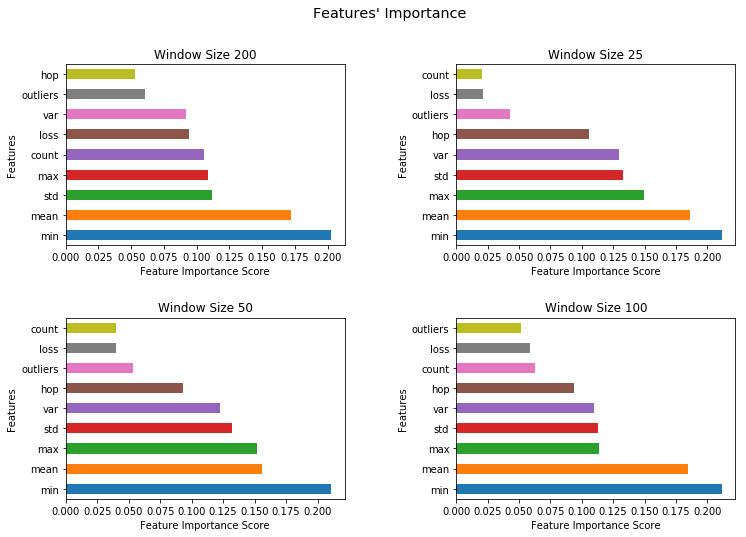

In [30]:
plots_analysis.random_forests_features_selection(trace_stats)

In [31]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [32]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [33]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [34]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [35]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

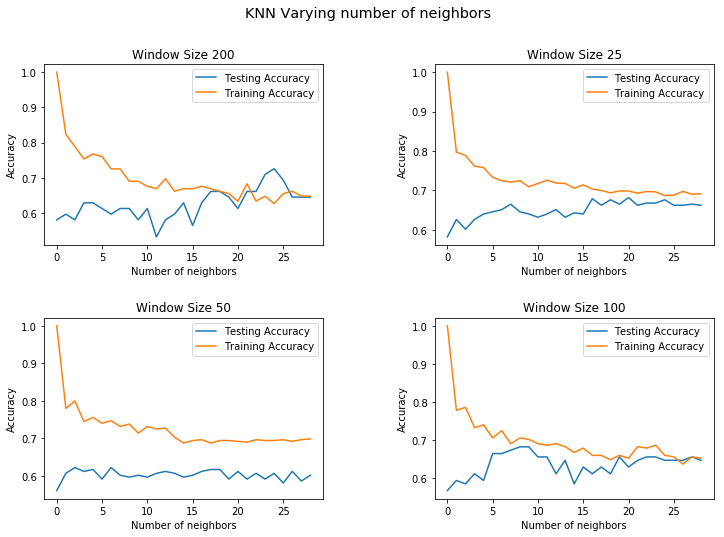

In [36]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [37]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [38]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=11)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [39]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [40]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [41]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [42]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [43]:

net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])


Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [44]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [45]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [46]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [47]:
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [48]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Per Node Results

Results from each model

In [49]:
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.725806,0.719048,0.698919,0.703516,0.105565,0.005421
1,Random Forest,25,0.797784,0.790548,0.774176,0.780240,0.163051,0.012312
2,Random Forest,50,0.801020,0.802210,0.781466,0.787755,0.120716,0.006674
3,Random Forest,100,0.787611,0.768596,0.762158,0.765073,0.098280,0.005728
4,KNN,200,0.612903,0.602116,0.604324,0.602564,0.000684,0.001534
5,KNN,25,0.631579,0.601261,0.591311,0.592340,0.000952,0.001233
6,KNN,50,0.596939,0.575437,0.570259,0.570068,0.001036,0.002613
7,KNN,100,0.654867,0.621275,0.619863,0.620511,0.000620,0.000703
8,SVM,200,0.596774,0.298387,0.500000,0.373737,0.002567,0.000499
9,SVM,25,0.617729,0.308864,0.500000,0.381849,0.018102,0.002959


Here we plot the average results for each model computed with cross validation

In [50]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.616585
1,Random Forest,25,0.762237
2,Random Forest,50,0.738708
3,Random Forest,100,0.652036
4,KNN,200,0.602317
5,KNN,25,0.654142
6,KNN,50,0.617334
7,KNN,100,0.563676
8,SVM,200,0.607805
9,SVM,25,0.627600


# Network Results

Here we print the results from each model on the whole network

In [51]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.5000,0.333333,0.333333,0.333333,0.088082,0.004978
1,Random Forest,25,0.5625,0.281250,0.500000,0.360000,0.085530,0.004846
2,Random Forest,50,0.5000,0.500000,0.500000,0.418182,0.084783,0.004967
3,Random Forest,100,0.3750,0.416667,0.433333,0.365079,0.088556,0.004983
4,KNN,200,0.2500,0.125000,0.500000,0.200000,0.000480,0.000692
5,KNN,25,0.5625,0.281250,0.500000,0.360000,0.000488,0.000413
6,KNN,50,0.1250,0.100000,0.125000,0.111111,0.000574,0.000617
7,KNN,100,0.3750,0.416667,0.433333,0.365079,0.000322,0.000577
8,SVM,200,0.2500,0.125000,0.500000,0.200000,0.000690,0.000650
9,SVM,25,0.5625,0.281250,0.500000,0.360000,0.001582,0.000442


Here we plot the average results for each model computed with cross validation

In [52]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.688889
1,Random Forest,25,0.567538
2,Random Forest,50,0.520833
3,Random Forest,100,0.466667
4,KNN,200,0.511111
5,KNN,25,0.567538
6,KNN,50,0.557870
7,KNN,100,0.616667
8,SVM,200,0.622222
9,SVM,25,0.615468
